
## 9.4 합성곱 신경망과 LSTM을 사용하는 시계열 데이터 인식 실습 (p375)
#### 9.4.1 데이터 개요  
  - http://www.cse.ust.hk/svc2004/download.html 에서 Task1 다운로드
  - 총 1600개 서명: 40명이 20회씩 진서명 800개, 각 위조서명 800개
  - 첫째 줄은 좌표의 갯수, 데이터의 1, 2번째 열은 각각 x,y 좌표, 3,4번째 열은 각각 좌표가 기록된 시간과 펜이 태블릿과 접촉되었는지 여부.   
    
#### 9.4.2 학습/데이터 파일 분리와 정답 정보 만들기  
  - 1600개 서명 데이터 순서섞기 & 파일명 변환  
  - 서명의 진/위조 여부 정답 파일 만들기

#### 9.4.3 데이터 읽기 및 전처리  
  - 사용자 정의 함수 생성  
  - 함수를 이용하여 데이터 읽어오기  
  - 정규화 이전의 데이터 구성 확인  
  - 데이터 정규화  
  - 정규화 이후의 서명 데이터 확인
  - 데이터의 진/위조 서명여부 확인 & 학습/테스트용 값 분리

#### 9.4.4 모델 구조 지정, 학습 및 테스트

### 9.4.2 학습/데이터 파일 분리와 정답 정보 만들기
- 데이터 파일 형태: U[사용자이름]S[서명번호].TXT  
- 서명번호 1 ~ 20번은 진 서명 / 21 ~ 40번은 위조서명  
- 학습/테스트를 위해 데이터의 순서를 섞고, 각 데이터가 진/위조서명인지 나타내는 별도 파일 생성

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls '/content/drive/MyDrive/Colab Notebooks/svc2004' | wc -l


# !ls : 파일 출력 명령
# wc -l: 줄 수 세는 명령
# | (Vertical Bar): 합집합, 또는

SyntaxError: ignored

In [ ]:
import subprocess

# Run the ls command and count the number of lines in the output
result = subprocess.run(['ls', '/content/drive/MyDrive/Colab Notebooks/svc2004'], stdout=subprocess.PIPE)
file_count = len(result.stdout.decode().splitlines())

print("Number of files and directories:", file_count)

Number of files and directories: 1600


In [ ]:
# 학습/테스트 데이터 분할을 위해 폴더 2개 생성
!mkdir '/content/drive/MyDrive/Colab Notebooks/svc2004/train'
!mkdir '/content/drive/MyDrive/Colab Notebooks/svc2004/test'

#### 1600개 서명 데이터 순서섞기 & 파일명 변환
- 0부터 1599까지의 숫자 섞어 배열에 저장
- 전체 서명을 순서대로 하나씩 이름 바꾸기

In [ ]:
import numpy as np
import shutil
import random
folderpath = '/content/drive/MyDrive/Colab Notebooks/svc2004'

# 0 ~ 1599 값을 가지는 배열(rand_number)을 생성 & 셔플
rand_number = np.array(range(1600))                                             # [   0    1    2 ... 1597 1598 1599]
random.seed(100)                                                                # 랜덤섞기 값 고정
np.random.shuffle(rand_number)

n_train = 1200
n_test = 400

In [ ]:
rand_number

array([  95,  623, 1541, ..., 1492,  750, 1239])

In [ ]:
rand_number

array([  95,  623, 1541, ..., 1492,  750, 1239])

In [ ]:
# 서명 파일 이름 변환 : U1S1 ~ U40S40 ---> 0 ~ 1599
# train(0~1199) / test(1200~1599) 폴더에 저장

cnt = 0
for u_id in range(1,41):      # 1~40
  for s_id in range(1,41):    # 1~40
    filepath_from = f'{folderpath}/U{u_id}S{s_id}.TXT'

                                                                                # 파일의 번호에 따라 학습용/테스트용 데이터로 나눔. rand_number[0] ~ rand_number[1599]
    if rand_number[cnt] < n_train:                                              # 1200 보다 작으면 train폴더로
      filepath_to = f'{folderpath}/train/{rand_number[cnt]}.TXT'                # 파일의 이름 rand_number로 변경
    else:                                                                       # 1200 보다 작으면 test폴더로
      filepath_to = f'{folderpath}/test/{rand_number[cnt]}.TXT'                 # 파일의 이름 rand_number로 변경
    shutil.move(filepath_from, filepath_to)                                     # shutil.move(src, dest) "src"파일 또는 디렉토리를 "dest"로 이동
    cnt = cnt + 1

'''
/U1S1.TXT
rand_number[0] = 95
/train/95.TXT

/U1S2.TXT
rand_number[1] = 623
/train/623.TXT

/U1S3.TXT
rand_number[2] = 1541
/train/1451.TXT
'''

'\n/U1S1.TXT\nrand_number[0] = 248\n/train/248.TXT\n\n/U1S2.TXT\nrand_number[1] = 792\n/train/792.TXT\n\n/U1S3.TXT\nrand_number[2] = 860\n/train/860.TXT\n\n. . .\n\nU40S38.TXT\nrand_number[1597] = 638\n/train/638.TXT\n\nU40S39.TXT\nrand_number[1598] = 1211\n/test/1211.TXT\n\nU40S40.TXT\nrand_number[1599] = 500\n/train/500.TXT\n'

#### 서명의 진/위조 여부 정답 파일 만들기

In [ ]:
# 각 서명의 진/위조 서명 여부를 저장한다.
b_genuine = np.zeros((1600,2))
b_genuine[:,0] = range(1600)
b_genuine

'''
array([[   0.,    0.],
       [   1.,    0.],
       [   2.,    0.],
       ...,
       [1597.,    0.],
       [1598.,    0.],
       [1599.,    0.]])
'''

'\narray([[   0.,    0.],\n       [   1.,    0.],\n       [   2.,    0.],\n       ...,\n       [1597.,    0.],\n       [1598.,    0.],\n       [1599.,    0.]])\n'

In [ ]:
# 정답 정보 구성
# s_id가 20 이하이면 진서명으로 값을 1로 지정
# s_id가 21 이상이면 위조서명으로 값을 1로 지정

cnt = 0
for u_id in range(1,41):                                                        # U1S1 ~ U40S40 : 1600번 반복 -> cnt 0 ~ 1599
  for s_id in range(1,41):
    if s_id < 21:                                                               # 절반은 진짜
      b_genuine[rand_number[cnt],1] = 1 #진서명
    else:                                                                       # 절반은 위조
      b_genuine[rand_number[cnt],1] = 0 #위조서명
    cnt = cnt + 1


'''
U1S"1"
b_genuine[rand_number[0],1] = 1
b_genuine[248,1] = 1

U1S"2"
b_genuine[rand_number[1],1] = 1
b_genuine[792,1] = 1

U1S"3"
b_genuine[rand_number[2],1] = 1
b_genuine[860,1] = 1
.
.
.
U40S"38"
b_genuine[rand_number[1597],1] = 0
b_genuine[638,1] = 0

U40S"39"
b_genuine[rand_number[1598],1] = 0
b_genuine[1211,1] = 0

U40S"40"
b_genuine[rand_number[1599],1] = 0
b_genuine[500,1] = 0
'''


'\nU1S"1"\nb_genuine[rand_number[0],1] = 1\nb_genuine[248,1] = 1\n\nU1S"2"\nb_genuine[rand_number[1],1] = 1\nb_genuine[792,1] = 1\n\nU1S"3"\nb_genuine[rand_number[2],1] = 1\nb_genuine[860,1] = 1\n.\n.\n.\nU40S"38"\nb_genuine[rand_number[1597],1] = 0\nb_genuine[638,1] = 0\n\nU40S"39"\nb_genuine[rand_number[1598],1] = 0\nb_genuine[1211,1] = 0\n\nU40S"40"\nb_genuine[rand_number[1599],1] = 0\nb_genuine[500,1] = 0\n'

In [ ]:
import pandas as pd

#진/위조서명 여부를 csv 파일로 저장한다.

# array 배열을 데이터프레임으로 저장
df_genuine = pd.DataFrame(b_genuine)

# 컬럼명 부여
df_genuine.columns = ['ID','bGenuine']

# 자료형 정수형으로 지정
df_genuine = df_genuine.astype('int32')

# 데이터프레임을 지정경로에 csv파일로 저장
df_genuine.to_csv(f'{folderpath}/train_info.csv', index=False)

In [ ]:
df_genuine

,ID,bGenuine
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
1595,1595,0
1596,1596,1
1597,1597,1
1598,1598,1


### 9.4.3 데이터 읽기 및 전처리
서명 데이터의 길이가 상이한 문제를 해결하기 위해, 3개 함수를 사용.  
  
1) get_max_len 함수: 전체 서명에서 가장 긴 서명의 길이 반환.   
2) load_data 함수: 주어진 폴더 전체의 서명을 읽고 저장.   
3) load_a_sig 함수: 서명 1개의 데이터를 읽어 반환.    

In [ ]:
import numpy as np
import os

#### 1) get_max_len 함수
 - 파라미터로 학습 및 테스트 폴더의 모든 서명데이터를 읽고,
 - 전체 서명의 길이 중 가장 긴 길이의 값을 반환한다.  
 - n_max_len: 전체 서명 데이터들 중 가장 긴 서명의 길이

In [ ]:
# folderpath = '/content/drive/MyDrive/Colab Notebooks/svc2004'

def get_max_len(folderpath_train, folderpath_test):
  n_max_len = 0
  for filename in os.listdir(folderpath_train):                                 # os.listdir 지정한 디렉토리 내의 모든 파일과 디렉토리의 리스트를 리턴 # 0~1199
    filepath = f'{folderpath_train}/{filename}'
    d, tmp = load_a_sig(filepath)

    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]                                                    # n_max_len = 9040

    for filename in os.listdir(folderpath_test):                                # 1200~1599
      filepath = f'{folderpath_test}/{filename}'
      d, tmp = load_a_sig(filepath)

      if d.shape[0] > n_max_len:
        n_max_len = d.shape[0]                                                  # n_max_len = 11964
  return n_max_len

In [ ]:
n_max_len = get_max_len( f'{folderpath}/train', f'{folderpath}/test')
n_max_len

793

#### 2) load_data 함수
- 파라미터로 주어진 폴더에 들어 있는 서명파일 전체를 읽고,
- n_files x n_max_len x 2 크기의 numpy 배열로 만들어 반환한다.
- 파라미터 n_max_len 은 전체 서명 데이터들 중 가장 긴 서명의 길이를 의미한다.
- 데이터와 함께 반환하는 len_sign는 각 서명의 실제 길이를 의미한다.

In [ ]:
                                                                                # for example
                                                                                # 3개의 파라미터
def load_data(folderpath, n_max_len, sig_ids):                                  # train, 793, range(n_train)
  filelist = os.listdir(folderpath)                                             # 폴더 내 파일 리스트 불러오기                  # 0.TXT ~ 1199.TXT
  n_files = len(filelist)                                                       # 파일의 개수를 n_files 변수에 저장             # 1200
  d = np.zeros((n_files,n_max_len,2))                                           # np.zeros 배열 생성: n_files x n_max_len x 2   # 1200 x 793 x 2
  len_sign = np.zeros(n_files)                                                  # np.zeros 배열 생성: n_files x 1               # 1200 x 1

                                                                                # 각 서명의 실제 길이 저장
  for i in sig_ids :                                                            # 0 ~ 1199 / 1200 ~ 1599
    filepath = f'{folderpath}/{i}.TXT'                                          # 파일이름을 지정한다.
    d_tmp, len_sign[i-sig_ids[0]] = load_a_sig(filepath)                        # load_a_sig 함수로 서명데이터 읽은 후,
    d[i-sig_ids[0],:d_tmp.shape[0],:] = d_tmp                                   # 임시 변수에 저장한다. # 준비한 배열(d)에 저장한다.
  return d, len_sign


#### 3) load_a_sig 함수
- 파라미터로 주어진 서명파일을 읽고, nPoint x 2 크기의 numpy 배열로 만들어 반환한다.  
  
관련 함수와 메소드
1. 객체 = open("파일경로.확장자명",'rt') : 읽기모드로 파일 열기/ 'wt' 쓰기모드  
R	파일이 읽기 모드  
W	파일에 쓰기 모드  
a	파일이 쓰기 모드로 열리고 내용이 끝에 추가  
rb	이진 데이터 읽기를 위해 파일 열기  
wb	이진 데이터를 쓰기 위해 파일 열기    

2. 읽기 시리즈  
.readline() : 파일의 첫번째 줄을 읽어 문자열로 반환  
.readlines() : 파일의 모든 라인을 읽어서 각각의 요소를 갖는 리스트로 반환    
.read() : 파일의 내용 전체를 문자열로 반환한다   



In [ ]:
def load_a_sig(filepath):
  f = open(filepath,'rt')                                                       # 파일열기 읽기모드
  nPoints = int(f.readline())                                                   # 데이터의 첫 줄을 nPoint 변수에 저장 233
  d = np.zeros((nPoints,2))                                                     # nPoints x 2 크기의 numpy 배열 만들기 233x2

  for i in range(nPoints):                                                      # 포인트의 개수만큼 반복하면서 (0 ~ nPoints-1) 0 ~ 232
    line = f.readline()                                                         # 각각의 줄을 읽고,
    toks = line.split(' ')                                                      # x,y 좌표를 분리하여
    d[i,:] = [int(toks[0]), int(toks[1])]                                       # 저장한다.
  f.close()

  return d, nPoints

#### [부록] .readline 메소드 사용법 살펴보기

In [ ]:
a = open('/content/drive/MyDrive/Colab Notebooks/svc2004/train/0.TXT', 'rt')
a

<_io.TextIOWrapper name='/content/drive/MyDrive/Colab Notebooks/svc2004/train/0.TXT' mode='rt' encoding='UTF-8'>

In [ ]:
ini = a.readline()
ini

'233\n'

In [ ]:
b = open('/content/drive/MyDrive/Colab Notebooks/svc2004/train/0.TXT', 'rt')
b

<_io.TextIOWrapper name='/content/drive/MyDrive/Colab Notebooks/svc2004/train/0.TXT' mode='rt' encoding='UTF-8'>

In [ ]:
ini = b.readline().strip()
ini

'233'

In [ ]:
ini = b.readline().strip()
ini

'4671 6572 1077319 0'

In [ ]:
toks = ini.split(' ')

In [ ]:
toks[0]

'4671'

In [ ]:
toks[1]

'6572'

In [ ]:
e = np.zeros((233,2))
e[0,:] = [int(toks[0]), int(toks[1])]
e[:10,:]

array([[4671., 6572.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.],
       [   0.,    0.]])

#### [부록] load_a_sig 함수 결과 예시 보기

In [ ]:
d1, nPoints1 = load_a_sig('/content/drive/MyDrive/Colab Notebooks/svc2004/train/1.TXT')  #185, 2408 4733 64509870 0

In [ ]:
d1[:10,:]

array([[2408., 4733.],
       [2379., 4705.],
       [2288., 4722.],
       [2249., 4757.],
       [2249., 4777.],
       [2232., 4801.],
       [2222., 4827.],
       [2238., 4853.],
       [2271., 4900.],
       [2356., 4960.]])

In [ ]:
nPoints1

185

#### 위 함수를 이용하여 데이터 읽어오기

In [ ]:
# 각 데이터의 길이를 체크하고 최대길이 확인
n_max_len = get_max_len( f'{folderpath}/train', f'{folderpath}/test')                # get_max_len 함수 : n_max_len 반환

In [ ]:
# 학습용 데이터 load
x_train, x_train_len = load_data(f'{folderpath}/train', n_max_len, range(n_train))   # load_data 함수 : d와 len_sign 반환 / d 1200x11946x2, len_sign 1200x1
x_train_len

array([349., 266., 400., ..., 147., 264., 298.])

In [ ]:
x_train

array([[[2051., 4210.],
        [2051., 4210.],
        [2058., 4236.],
        ...,
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.]],

       [[6335., 4436.],
        [6372., 4571.],
        [6354., 4598.],
        ...,
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.]],

       [[1304., 6679.],
        [1252., 6594.],
        [1224., 6609.],
        ...,
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.]],

       ...,

       [[2347., 4992.],
        [2318., 4998.],
        [2282., 5024.],
        ...,
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.]],

       [[3722., 4080.],
        [3722., 4080.],
        [3698., 4107.],
        ...,
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.]],

       [[1993., 6689.],
        [1910., 6584.],
        [1841., 6605.],
        ...,
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.]]])

In [ ]:
x_train.shape

(1200, 793, 2)

In [ ]:
# 테스트용 데이터 load 400
x_test, x_test_len = load_data(f'{folderpath}/test', n_max_len, range(n_train,1600)) # load_data 함수 : d와 len_sign 반환
x_test_len

array([208., 134., 215., 172., 304., 329., 161., 252., 245., 289., 224.,
       250., 111., 359., 214., 314., 326., 149., 223., 201., 267., 640.,
       408., 147., 121., 118., 274., 323., 195., 233., 476., 154., 122.,
       186., 425., 140., 138., 416., 158., 302., 312., 127., 359., 326.,
       129., 200., 201., 236., 202., 260., 419., 123., 204., 236., 192.,
       371., 111., 233., 227., 368., 147., 221., 191., 159., 146., 357.,
       136., 225., 188., 306., 211., 218., 347., 168., 177., 142., 130.,
       246., 196., 292., 229., 235., 230., 337., 283., 187., 206., 355.,
       218., 168., 290., 239., 126., 221., 480., 151., 113., 335., 240.,
       203., 350., 193., 210., 116., 212., 247., 276., 230., 127., 217.,
       474., 120., 273., 359., 182., 230., 519., 115., 261., 340., 321.,
       281., 425., 252., 508., 595., 121., 312., 327., 239., 406., 214.,
       126., 339., 217., 294., 197., 255., 182., 457., 334., 154., 163.,
       254., 201., 177., 194., 148., 472., 331., 20

In [ ]:
x_test.shape

(400, 793, 2)

#### 정규화 이전의 데이터 구성 확인

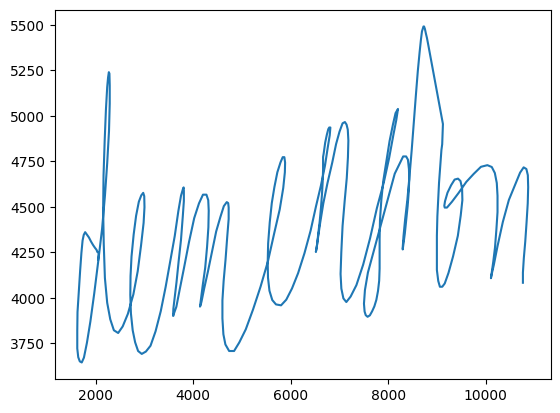

In [ ]:
import matplotlib.pyplot as plt

s_id = 0
len_sig = int(x_train_len[s_id])
plt.plot(x_train[s_id,:len_sig,0],x_train[s_id,:len_sig,1])

'''
len_sig = int(x_train_len[0])
len_sig = int(349)
len_sig = 349

plt.plot(x_train[0,:349,0],x_train[0,:349,1])
'''

#### 데이터 정규화
 - 서명 데이터의 값을 0에서 1 사이 값으로 정규화  
 - 각 데이터에 대해 너비/높이의 최솟/최댓값을 구하고, 0과 1사이 값으로 정규화  
 - 높이/너비 비율이 중요하므로, 이 비율을 미리 계산해두고 마지막에 곱하여 y 보정

In [ ]:
# 학습용 데이터 정규화
for i in range(x_train.shape[0]):                                               # range(1200)
  len_tmp = int(x_train_len[i])                                                 # i=0 일 때, len_tmp = 349
  h_min = np.min(x_train[i,:len_tmp,0])                                         # np.min(x_train[0, :349, 0])
  h_max = np.max(x_train[i,:len_tmp,0])                                         # np.max(x_train[0, :349, 0])
  v_min = np.min(x_train[i,:len_tmp,1])                                         # np.min(x_train[0, :349, 1])
  v_max = np.max(x_train[i,:len_tmp,1])                                         # np.max(x_train[0, :349, 1])

  w_h_ratio = (v_max - v_min)/ (h_max - h_min)                                  # height / width 비율

  x_train[i,:len_tmp,0] = (x_train[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_train[i,:len_tmp,1] = (x_train[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio

  '''
for i in range(1200):
  len_tmp = int(x_train_len[0])
  len_tmp = int(349)                                                            # i=0 일 때, len_tmp = 349, i=1일 때 len_tmp = 266, i=2일 때 len_tmp = 400
  h_min = np.min(x_train[0, :349, 0])                                           # 가로 최솟값
  h_max = np.max(x_train[0, :349, 0])                                           # 가로 최댓값
  v_min = np.min(x_train[0, :349, 1])                                           # 세로 최솟값
  v_max = np.max(x_train[0, :349, 1])                                           # 세로 최댓값

  w_h_ratio = (v_max - v_min)/ (h_max - h_min)                                  # 높이/너비 비율

  x_train[0,:349,0] = (x_train[0,:349,0] - 세로 최솟값) / (높이)
  x_train[0,:349,1] = (x_train[i,:349,1] - 가로 최솟값) / (너비) * 높이/너비 비율 # y값 보정
  '''

In [ ]:
# 테스트 데이터 정규화
for i in range(x_test.shape[0]):
  len_tmp = int(x_test_len[i])
  h_min = np.min(x_test[i,:len_tmp,0])
  h_max = np.max(x_test[i,:len_tmp,0])
  v_min = np.min(x_test[i,:len_tmp,1])
  v_max = np.max(x_test[i,:len_tmp,1])
  w_h_ratio = (v_max - v_min)/ (h_max - h_min)
  x_test[i,:len_tmp,0] = (x_test[i,:len_tmp,0] - h_min) / (h_max - h_min)
  x_test[i,:len_tmp,1] = (x_test[i,:len_tmp,1] - v_min) / (v_max - v_min) * w_h_ratio

#### 정규화 이후의 서명 데이터 확인

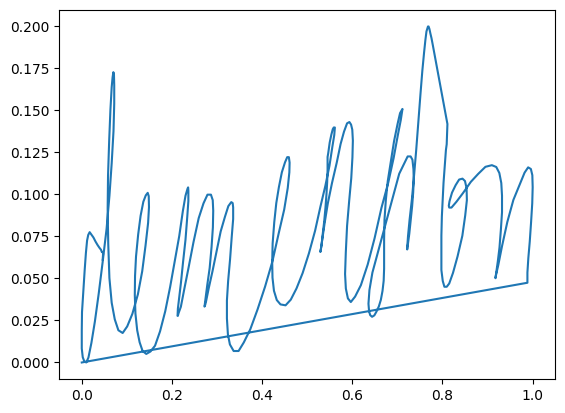

In [ ]:
import matplotlib.pyplot as plt
s_id = 0
plt.plot(x_train[s_id,:,0],x_train[s_id,:,1])

# plt.plot(x_train[0,:,0],x_train[0,:,1])

#### 데이터의 진/위조 서명여부 확인 & 학습/테스트용 값 분리

In [ ]:
import pandas as pd
from tensorflow import keras

#파일에서 정답(출력) 정보 획득
#train_info.csv 파일은 9.4.2절의 마지막 코드에서 만든 파일
y_pd = pd.read_csv(f'{folderpath}/train_info.csv')
y_all = np.array(y_pd['bGenuine'])

#학습/테스트 데이터 분할 및 원-핫 인코딩
y_train = y_all[:n_train]
y_train_cat = keras.utils.to_categorical(y_train)
y_test = y_all[n_train:]

In [ ]:
y_pd

,ID,bGenuine
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
1595,1595,0
1596,1596,1
1597,1597,1
1598,1598,1


In [ ]:
y_all

array([1, 1, 0, ..., 1, 1, 0])

### 9.4.4 모델 구조 지정, 학습 및 테스트
#### 학습을 위해 모델의 기본 구조 지정
##### 네트워크 구조:

*   합성곱층 6개
*   MaxPooling층 3개
*   LSTM층 1개  
*   [추가] 드롭아웃층 - 오버피팅 방지 효과
*   완전연결층 1개








### 9.3.2 합성곱층의 파라미터

model.add(Conv1D(filters, kernel_size, activation))  
 - 시계열 데이터에서 사용하는 1차원 합성곱층  

1) filter  
 - 합성곱을 수행하는 가중치의 세트.
 - 필터의 갯수가 많을수록 보다 다양한 특징 추출.
 - 필터 수가 클수록 올바르게 학습된 네트워크의 성능은 향상되지만, 네트워크를 학습시키는 것은 더욱 어려워짐.
 - 과도한 수의 필터를 사용하여 학습을 시도한 후 크기를 조금씩 줄여나가거나, 여러 개의 합성곱층을 사용하면서 필터수를 조금씩 늘려나가는 방식으로 해결.여러개의 합성곱층을 사용할 때에는 일반적으로 필터 수를 2의 배수로 증가시킨다.  

2) padding  
 - 출력 크기를 보정하기 위해 입력 데이터의 사방을 특정값으로 채우는 것.  
 - padding='same' 출력 크기를 입력 크기와 동일하게 유지. 입력데이터 (Hi,Wi)와 (F,F) 사이즈의 필터가 있을 때, same padding 의 폭 P는 (F-1)/2. 입력데이터의 크기는 (Hi+2*P,Wi+2*P)  
 - padding='valid' 패딩을 추가하지 않은 상태. valid padding을 통과하면 그 결과는 항상 입력사이즈보다 작게 된다.

3) kernel_size  
 - 가중치 배열의 크기.
 - kernel_size = 3 이면 커널의 크기가 (3,3).
 - 커널 크기가 클수록 넓은 범위를 포괄하는 특징을 찾고, 작을수록 지엽적인 특징을 추출하는 필터가 만듦
   
4) activation  
 - 각 층에서 발생하는 출력을 변형시키는 역할.   
 - sigmoid: 출력값 0 ~ 1  
 - ReLU: 출력값 0보다 작은 값은 0, 다른 것은 그대로.
 - Tanh: 출력값 -1 ~ 1  
 - Softmax: 출력 노드들의 값의 합이 1이 되도록 출력 조정. 분류 모델에서 마지막 층에 사용  
  
5) pooling층의 파라미터  
- 노드의 수(특징의 갯수)를 줄이기 위해 사용.  
- pool/stride의 크기가 클수록 특징의 갯수 대폭 감소, 학습 난이도 감소, 정보 손실 증가.  
- 딥 네트워크: 여러개의 합성곱층과 풀링층을 같이 사용. n:1 비율로 구성하기도 함.  


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

#모델 구조 지정
model = Sequential()                                                            # 시계열 모델 생성
model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu'))          # 1차원 합성곱층: 시계열 데이터에서 사용. 여러개의 합성곱층을 사용하면서 필터수를 조금씩 늘림(2배수)
model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu'))          # ReLU 활성화함수 사용. 합성곱층과 완전연결층에서 주로 사용.
model.add(MaxPooling1D(pool_size=3, strides=2))                                 # MaxPooling층: 이미지 데이터 네트워크에서 사용. 2:1로 합성곱과 풀링층 세트를 3개 연속 구성.
model.add(Conv1D(16, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, input_dim=2))
model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, input_dim=2))
model.add(Bidirectional(LSTM(128)))                                             # LSTM층: 단일출력 가능하나, 합성곱층과 함께 사용하여 성능 향상.
model.add(Dropout(0.3))                                                         # 드롭아웃층: 오버피팅 방지 효과
model.add(Dense(units=2, activation='softmax'))                                 # 완전연결층: 완전연결층을 지나게 되면 데이터 순서사라짐. 출력 직전에 사용. 출력노드 값의 합이 1이 되는 소프트맥스 함수 사용. 2개(진/위)로 분류하기 위해 units=2


### 9.3.6 학습 파라미터와 오버피팅
1) epochs  
 - 전체 데이터를 몇 번 반복해서 학습 시킬 것인가.  

2) batch_size  
 - 몇 개의 데이터 샘플을 한 번에 학습시킬 것인가.   
  
3) validataion_split (검증데이터 비율)    
 - 학습/검증 데이터 나누는 비율

In [ ]:
# 실행을 위한 코드 추가
from keras.optimizers import Adam

In [ ]:
#모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#학습
hist = model.fit(x=x_train, y=y_train_cat, epochs=80, validation_split=0.3, batch_size=16)

Epoch 1/80
53/53 [==============================] - 10s 111ms/step - loss: 0.1338 - accuracy: 0.9464 - val_loss: 0.6159 - val_accuracy: 0.8167
Epoch 2/80
53/53 [==============================] - 6s 112ms/step - loss: 0.0890 - accuracy: 0.9702 - val_loss: 0.7094 - val_accuracy: 0.7972
Epoch 3/80
53/53 [==============================] - 6s 104ms/step - loss: 0.0606 - accuracy: 0.9774 - val_loss: 0.7180 - val_accuracy: 0.8028
Epoch 4/80
53/53 [==============================] - 5s 97ms/step - loss: 0.0867 - accuracy: 0.9714 - val_loss: 0.6742 - val_accuracy: 0.8306
Epoch 5/80
53/53 [==============================] - 6s 119ms/step - loss: 0.0411 - accuracy: 0.9881 - val_loss: 0.6974 - val_accuracy: 0.8278
Epoch 6/80
53/53 [==============================] - 5s 98ms/step - loss: 0.0514 - accuracy: 0.9845 - val_loss: 0.7279 - val_accuracy: 0.8083
Epoch 7/80
53/53 [==============================] - 6s 121ms/step - loss: 0.0720 - accuracy: 0.9702 - val_loss: 0.9188 - val_accuracy: 0.7917
Epoch 8

In [ ]:
# 테스트 데이터를 사용하여 예측(결과 추정)
o = model.predict(x_test)

# 정확도 체크 (딥러닝 학습의 랜덤성을 고려하여 대체로 85%내외의 정확도 획득)
o = np.argmax(o,1)
sum(np.equal(y_test,o))/len(y_test)


13/13 [==============================] - 1s 39ms/step


0.85